In [2]:
pip install cfgrib xarray pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 24.3 MB/s eta 0:00:00


In [3]:
!pip install pygrib
!pip install cdsapi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 12.9 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import cdsapi
import xarray as xr
import matplotlib.pyplot as plt

Preparing the data from NDBC

In [5]:
# Parameters
station_ids = ["44093"] # Check this to which station you want to work on
years = range(2015, 2017)  # Years to fetch data for 2015 to 2016
# if you need one additional year, add 1 e.g., for from 2015 to 2017, use range(2015,2018)

# Store results
dfs = {}

# Fetch data for each station
for station in station_ids:
    frames = []
    for year in years:
        url = f"https://www.ndbc.noaa.gov/view_text_file.php?filename={station}h{year}.txt.gz&dir=data/historical/stdmet/"
        try:
            df = pd.read_csv(
                url,
                delim_whitespace=True,
                skiprows=[1],
                na_values=['MM', '999', '99.0', '9999.0']  # Handle NAs directly
            )
            df['Year'] = year  # Add year column
            frames.append(df)
        except Exception as e:
            print(f"Failed to load {station} {year}: {e}")

    # Combine yearly data
    if frames:
        full_df = pd.concat(frames, ignore_index=True)
        dfs[station] = full_df
        print(f" Data loaded for station {station} ({years.start})")
    else:
        print(f" No data found for station {station} ({years.start})")

# === Clean and Process NDBC Data ===
ndbc_df = dfs["44093"].copy()

# Rename time columns
rename_map = {'#YY': 'Year', 'MM': 'Month', 'DD': 'Day', 'hh': 'Hour', 'mm': 'Minute'}
ndbc_df.rename(columns={k: v for k, v in rename_map.items() if k in ndbc_df.columns}, inplace=True)

# Remove duplicate columns
ndbc_df = ndbc_df.loc[:, ~ndbc_df.columns.duplicated()]

# Create timestamp
ndbc_df['timestamp'] = pd.to_datetime(ndbc_df[['Year', 'Month', 'Day', 'Hour', 'Minute']], errors='coerce')

# Drop raw date columns
ndbc_df.drop(columns=[col for col in ['Year', 'Month', 'Day', 'Hour', 'Minute'] if col in ndbc_df.columns], inplace=True)

# Drop columns with all NaNs and sort by time
ndbc_df.dropna(axis=1, how='all', inplace=True)
ndbc_df.sort_values('timestamp', inplace=True)

# Round to nearest hour and aggregate duplicates (to match ERA5 hourly freq)
ndbc_df['timestamp'] = ndbc_df['timestamp'].dt.round('H')
ndbc_df = ndbc_df.groupby('timestamp').mean(numeric_only=True).reset_index()

# Check the tail of the dataframe, keep informed the end year period
# because if you use multi year data, there might be a chance have a whole year missing value
print(" Final NDBC DataFrame:")
print(ndbc_df.info())
print(ndbc_df.head(10))


<ipython-input-5-52219dbaebe5>:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
<ipython-input-5-52219dbaebe5>:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


 Data loaded for station 44093 (2015)
 Final NDBC DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16203 entries, 0 to 16202
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  16203 non-null  datetime64[ns]
 1   WVHT       16203 non-null  float64       
 2   DPD        16203 non-null  float64       
 3   APD        16203 non-null  float64       
 4   MWD        16172 non-null  float64       
 5   WTMP       16203 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 759.6 KB
None
            timestamp   WVHT     DPD    APD    MWD  WTMP
0 2015-01-11 23:00:00  0.460   9.810  5.930  119.0  8.45
1 2015-01-12 00:00:00  0.460   9.485  6.205  124.0  8.35
2 2015-01-12 01:00:00  0.475   9.810  6.270  123.0  8.25
3 2015-01-12 02:00:00  0.475   9.880  6.420  119.0  8.30
4 2015-01-12 03:00:00  0.460   9.810  6.400  118.5  8.30
5 2015-01-12 04:00:00  0.455  10.205  6.555  11

<ipython-input-5-52219dbaebe5>:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ndbc_df['timestamp'] = ndbc_df['timestamp'].dt.round('H')


Use CDSAPI to import data from ERA5, which help us have more consistent data; this way we don't have to use interpolation or drop the null value!

You need a key for this, register at Copernicus Data Sotre first: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=overview

Replace your own API key below, you could use mine

In [6]:
url = 'url: https://cds.climate.copernicus.eu/api'
key = 'key: f9dbbc70-b431-4b34-bdbf-47322af5fc61'

with open('/root/.cdsapirc', 'w') as f:
    f.write('\n'.join([url, key]))

with open('/root/.cdsapirc') as f:
    print(f.read())

url: https://cds.climate.copernicus.eu/api
key: f9dbbc70-b431-4b34-bdbf-47322af5fc61


In [7]:
c = cdsapi.Client()

2025-04-01 17:19:49,801 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-01 17:19:49,803 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


If you run this more than 3 years data, it should take more than 15 minutes

In [8]:
dataset = "reanalysis-era5-single-levels"
request = {
    "product_type": ["reanalysis"],
    "variable": ["significant_height_of_combined_wind_waves_and_swell"],
    "year": ["2015", "2016","2017"],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "day": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12",
        "13", "14", "15",
        "16", "17", "18",
        "19", "20", "21",
        "22", "23", "24",
        "25", "26", "27",
        "28", "29", "30",
        "31"
    ],
    "time": [
        "00:00", "01:00", "02:00",
        "03:00", "04:00", "05:00",
        "06:00", "07:00", "08:00",
        "09:00", "10:00", "11:00",
        "12:00", "13:00", "14:00",
        "15:00", "16:00", "17:00",
        "18:00", "19:00", "20:00",
        "21:00", "22:00", "23:00"
    ],
    "data_format": "grib",
    "download_format": "unarchived",
    "area": [37.5, -75.5, 36.5, -74] # Check this coorinate to nearest station id
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()


2025-04-01 17:19:51,939 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-01 17:19:51,941 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-01 17:19:52,863 INFO Request ID is 22ce73cd-4586-4a2e-bb73-56954067f37b
INFO:datapi.legacy_api_client:Request ID is 22ce73cd-4586-4a2e-bb73-56954067f37b
2025-04-01 17:19:53,460 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-04-01 17:19:58,829 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been 

cf5cc36b5c37381a5b26b0e815a7600e.grib:   0%|          | 0.00/3.31M [00:00<?, ?B/s]

'cf5cc36b5c37381a5b26b0e815a7600e.grib'

In [9]:
# Load ERA5 GRIB (entire data, all locations)
era5_ds = xr.open_dataset("/content/cf5cc36b5c37381a5b26b0e815a7600e.grib", engine="cfgrib")

# Convert to dataframe
era5_df = era5_ds.to_dataframe().reset_index()

# Just pick **one** available point (e.g., the first row of unique lat/lon combo)
sample_point = era5_df[["latitude", "longitude"]].drop_duplicates().iloc[0]
lat, lon = sample_point["latitude"], sample_point["longitude"]

# Filter to that single point
era5_point_df = era5_df[
    (era5_df["latitude"] == lat) &
    (era5_df["longitude"] == lon)
].copy()

# Create timestamp
era5_point_df["timestamp"] = pd.to_datetime(era5_point_df["time"])

# Keep only what's needed
df_era5 = era5_point_df[["timestamp", "swh"]].rename(columns={"swh": "WVHT"})


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


In [10]:
print(df_era5)

                 timestamp      WVHT
0      2015-01-01 00:00:00  0.378843
12     2015-01-01 01:00:00  0.347169
24     2015-01-01 02:00:00  0.328844
36     2015-01-01 03:00:00  0.344051
48     2015-01-01 04:00:00  0.402470
...                    ...       ...
315588 2017-12-31 19:00:00  0.981018
315600 2017-12-31 20:00:00  1.076004
315612 2017-12-31 21:00:00  1.200209
315624 2017-12-31 22:00:00  1.201542
315636 2017-12-31 23:00:00  1.197124

[26304 rows x 2 columns]


In [11]:
# Step 1: Ensure timestamps are datetime and set as index
df_era5["timestamp"] = pd.to_datetime(df_era5["timestamp"])
ndbc_df["timestamp"] = pd.to_datetime(ndbc_df["timestamp"])

df_era5.set_index("timestamp", inplace=True)
ndbc_df.set_index("timestamp", inplace=True)

# Step 2: Left join — ERA5 as base (full year), inject NDBC where available
merged_df = df_era5.join(ndbc_df[["WVHT"]], how="left", lsuffix="_era5", rsuffix="_ndbc")

# Step 3: Prefer NDBC if present, otherwise use ERA5
merged_df["WVHT_final"] = merged_df["WVHT_ndbc"].combine_first(merged_df["WVHT_era5"])

# Step 4: Final cleanup
final_df = merged_df[["WVHT_final"]].rename(columns={"WVHT_final": "WVHT"}).reset_index()

# Sort Timestamp
final_df.sort_values("timestamp", inplace=True)

print(final_df.head())


            timestamp      WVHT
0 2015-01-01 00:00:00  0.378843
1 2015-01-01 01:00:00  0.347169
2 2015-01-01 02:00:00  0.328844
3 2015-01-01 03:00:00  0.344051
4 2015-01-01 04:00:00  0.402470


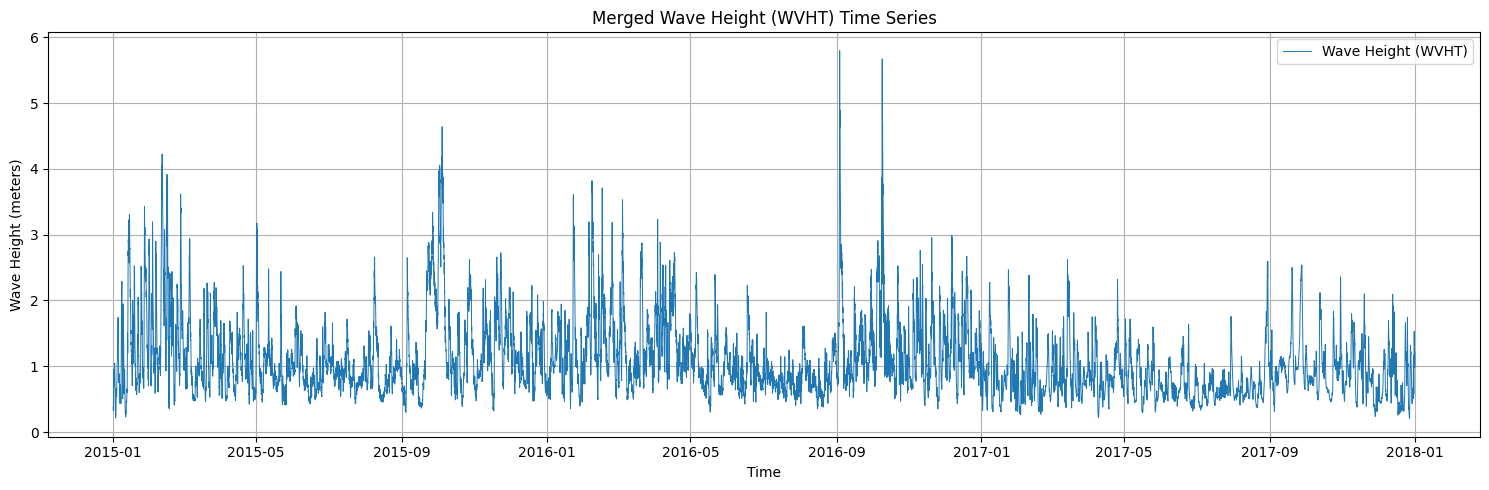

In [12]:
# Plot time series
plt.figure(figsize=(15, 5))
plt.plot(final_df["timestamp"], final_df["WVHT"], label="Wave Height (WVHT)", linewidth=0.7)

# Format the plot
plt.title("Merged Wave Height (WVHT) Time Series")
plt.xlabel("Time")
plt.ylabel("Wave Height (meters)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()